# Development and Testing Notebook

## Strategy Development

### Available data

In [1]:
import os
from pathlib import Path
from dotenv import load_dotenv
load_dotenv()
tick_path = os.getenv("TICK_PATH", "").split(os.pathsep)[0]

p = Path(tick_path)
if p.is_dir(): 
    available_ticks =[f.name.replace('.parquet', '') for f in p.iterdir() if f.is_file()]

In [2]:
import options_wizard as ow
from functools import partial
from operator import ne, ge, le

universe = ow.Universe(['AAPL'])
pipeline = ow.Pipeline(universe=universe, saves=[ow.SaveFrames.DATA, ow.SaveFrames.STRAT])
kwargs = {
    'keep_val': ['c', 120, 0],
    'keep_col' : ['call_put', 'ttm', 'n_missing'],
    'keep_oper': [ne, le, le],
    }

ow.wrap_fn = partial(ow.wrap_fn, pipeline=pipeline, kwargs=kwargs)

### Function definitions

In [3]:


@ow.wrap_fn(ow.FuncType.LOAD)
def load_data(**kwargs) -> ow.DataType:
    """Loads in data for the tick"""
    
    # -- Imports --
    from dotenv import load_dotenv
    import os
    import polars as pl

    # -- Load Data --
    load_dotenv()
    tick = kwargs.get("tick", "")
    tick_path = os.getenv("TICK_PATH", "")
    data = pl.read_parquet(os.path.join(tick_path, f"{tick}.parquet"))

    return ow.DataType(data, tick)

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def filter_gaps(data: ow.DataType, **kwargs) -> ow.DataType:
    import polars as pl

    df = data()

    df = df.with_columns(pl.col("trade_date").cast(pl.Date))
    keys = ["call_put", "strike", "expiry_date"]

    # Build calendar index
    calendar = (
        df.select("trade_date")
          .unique()
          .sort("trade_date")
          .with_row_index("day_idx")
    )
    cal_dates = calendar["trade_date"].to_list()

    # Bounds for each contract
    contract_bounds = (
        df.group_by(keys)
          .agg([
              pl.col("trade_date").min().alias("start"),
              pl.col("trade_date").max().alias("end"),
              pl.col("trade_date").alias("present_dates")
          ])
    )

    bounds = (
        contract_bounds
        .join(calendar.rename({"trade_date": "start"}), on="start", how="left")
        .rename({"day_idx": "start_idx"})
        .join(calendar.rename({"trade_date": "end"}), on="end", how="left")
        .rename({"day_idx": "end_idx"})
    )

    # Compute missing days
    def compute_missing(s):
        p = set(s["present_dates"])
        if s["start_idx"] is None or s["end_idx"] is None:
            return []
        expected = cal_dates[s["start_idx"] : s["end_idx"] + 1]
        return [d for d in expected if d not in p]

    bounds = bounds.with_columns(
        pl.struct(["present_dates", "start_idx", "end_idx"])
            .map_elements(compute_missing)
            .alias("missing_days")
    ).with_columns(
        pl.col("missing_days").list.len().alias("n_missing")
    )

    bounds = bounds.with_columns(
        (pl.col("end") - pl.col("start")).alias("_tmp")  # ensure cast
    )

    # Join last_trade_date into df
    df2 = (
        df.join(
            bounds.select(keys + ["end", "missing_days", "n_missing"]),
            on=keys,
            how="left"
        )
        .with_columns(
            (pl.col("end") - pl.col("trade_date"))
            .alias("days_until_last_trade")
        )
    )

    return ow.DataType(df2, kwargs.get("tick", ""))

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def ttms(data: ow.DataType, **kwargs) -> ow.DataType:
    """Adds time to maturity column to data."""
    # -- Imports --
    import polars as pl
    from datetime import datetime

    # -- Calculate TTM --
    df = data().with_columns(
        (
            (pl.col("expiry_date").cast(pl.Date) - pl.col("trade_date").cast(pl.Date))
            .dt.total_days()
        ).alias("ttm")
    )
    return ow.DataType(df, kwargs.get("tick", ""))

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def filter_out(data: ow.DataType, **kwargs) -> ow.DataType:
    """Drops option type column from data."""
    # -- Imports --
    import polars as pl
    from typing import List, Any
    from functools import reduce
    import operator as op

    # -- Get Args --
    keep: str | List[Any] = kwargs.get("keep_val", "")
    col: str | List['str'] = kwargs.get("keep_col", "")
    oper = kwargs.get("keep_oper", "")
    tick = kwargs.get("tick", "")

    # -- Dealing with single values --
    if isinstance(keep, str):
        keep = [keep]
    if isinstance(col, str):
        col = [col]
    if not isinstance(oper, list):
        oper = [oper] 

    # -- Drop Column --
    df = data()
    exprs = [o(pl.col(c), d) for d, c, o in zip(keep, col, oper)]
    df = df.filter(reduce(op.and_, exprs))
    return ow.DataType(df, tick)

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def underlying_close(data: ow.DataType, **kwargs) -> ow.DataType:
    """Adds underlying close price to data."""
    # -- Imports --
    import yfinance as yf
    import polars as pl

    # -- Get Underlying Data --
    tick = kwargs.get("tick", "")
    ticker = yf.Ticker(tick)

    # -- Download History --
    df = data()
    start = df.select(pl.col("trade_date").min()).item()
    end = df.select(pl.col("trade_date").max()).item()
    hist = ticker.history(
        start=start.strftime("%Y-%m-%d"),
        end=end.strftime("%Y-%m-%d"),
        auto_adjust=False,
        interval="1d",
    ).reset_index()

    # -- Normalise date --
    hist["Date"] = hist["Date"].dt.tz_localize(None)

    # -- Merge Data --
    hist_pl = (
        pl.from_pandas(hist)
        .with_columns(
            pl.col("Date").dt.date().alias("trade_date")
        )
        .rename({"Close": "underlying_close"})
        .select(["trade_date", "underlying_close"])
    )

    merged_df = df.join(hist_pl, on="trade_date", how="left")

    return ow.DataType(merged_df, tick)


@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data])
def scale_splits(data: ow.DataType, **kwargs) -> ow.DataType:
    """Scales data for stock splits using Polars expressions."""
    # -- Imports --
    import yfinance as yf
    import polars as pl

    # -- Get Splits --
    tick = kwargs.get("tick", "")
    ticker = yf.Ticker(tick)
    splits = ticker.splits

    # -- Edge handling --
    if splits.empty:
        return data

    # -- Process Splits --
    splits = (
        splits.reset_index()
        .rename(columns={"index": "Date", "Stock Splits": "Split"})
    )
    splits["Date"] = splits["Date"].dt.tz_localize(None)
    splits = splits.sort_values("Date")
    cols_to_reduce = ["last_trade_price", "bid_price", "ask_price", "strike"]
    cols_to_increase = ["volume", "open_interest"]

    # -- Apply Splits --
    df = data()
    for date, ratio in zip(splits["Date"], splits["Split"]):
        df = df.with_columns([
            pl.when(pl.col("trade_date") < date)
              .then(pl.col(col) / ratio)
              .otherwise(pl.col(col))
              .alias(col) for col in cols_to_reduce
        ] + [pl.when(pl.col("trade_date") < date)
              .then(pl.col(col) * ratio)
              .otherwise(pl.col(col))
              .alias(col) for col in cols_to_increase
        ])

    return ow.DataType(df, tick)

@ow.wrap_fn(ow.FuncType.DATA, depends_on=[load_data, filter_gaps, ttms, filter_out, underlying_close, scale_splits])
def ratio_spread(data: ow.DataType,**kwargs) -> ow.DataType:
    """
    Generate ratio spread entries per day using Polars.
    """

    import polars as pl

    lower_ttm   = kwargs.get('lower_ttm', 90)
    upper_ttm   = kwargs.get('upper_ttm', 150)
    delta_atm   = kwargs.get('delta_atm', 0.45)
    delta_otm   = kwargs.get('delta_otm', 0.15)
    otm_ratio   = kwargs.get('otm_ratio', 2)
    hold_period = kwargs.get('hold_period', 30)
    call_put    = kwargs.get('call_put', 'p')
    tick        = kwargs.get('tick', '')

    df = data()

    eligible = df.filter(
        (pl.col("call_put") == call_put)
        & (pl.col("ttm").is_between(lower_ttm, upper_ttm))
        & ((pl.col("delta").abs()) <= delta_atm)
        & (pl.col("days_until_last_trade") > hold_period)
    )

    atm = (
        eligible
        .with_columns((pl.col("delta").abs() - delta_atm).abs().alias("atm_rank"))
        .sort(["trade_date", "atm_rank"])
        .group_by("trade_date")
        .head(1)
        .with_columns([
            pl.lit(True).alias("entered"),
            pl.lit(-1).alias("position")      
        ])
        .select(df.columns + ["entered", "position"])
    )

    otm = (
        eligible
        .filter(pl.col("delta").abs() > delta_otm)
        .with_columns((pl.col("delta").abs() - delta_otm).abs().alias("otm_rank"))
        .sort(["trade_date", "otm_rank"])
        .group_by("trade_date")
        .head(1)
        .with_columns([
            pl.lit(True).alias("entered"),
            pl.lit(otm_ratio).alias("position")   
        ])
        .select(df.columns + ["entered", "position"])
    )

    entries = pl.concat([atm, otm], how="vertical")

    df_out = (
        df
        .join(entries, on=df.columns, how="left")
        .with_columns([
            pl.col("entered").fill_null(False),
            pl.col("position").fill_null(0)
        ])
    )

    return ow.DataType(df_out, tick)

@ow.wrap_fn(ow.FuncType.STRAT, depends_on=[ratio_spread])
def fixed_hold_trade(data: ow.DataType, **kwargs) -> ow.StratType:
    """Implements a fixed hold trading strategy."""
    
    from collections import deque
    from functools import lru_cache
    import polars as pl
    from options_wizard import (
        DateObj, Option, OptionType, Spot, 
        EntryData, PositionType, PriceSeries
    )

    @lru_cache(None)
    def date_obj(dt):
        return DateObj(day=dt.day, month=dt.month, year=dt.year)

    df = data()
    df = df.sort("trade_date")

    tick = kwargs.get("tick", "")
    hold_period = kwargs.get("hold_period", 30)

    # --- Pre-group by contract characteristics ---
    grouped = df.group_by(["call_put", "strike", "expiry_date"])

    # Build a dict: key → Polars DataFrame
    contract_map = {
        (k[0], k[1], k[2]): group
        for k, group in grouped
    }

    trade_entries = df.filter(pl.col("entered") == True)
    trades = deque()

    for trade in trade_entries.iter_rows(named=True):
        key = (trade["call_put"], trade["strike"], trade["expiry_date"])

        group = contract_map.get(key)
        if group is None:
            continue

        trade_start = trade["trade_date"]
        trade_end   = trade_start + pl.duration(days=hold_period)

        feasible = group.filter(
            (pl.col("trade_date").is_not_null()) &
            (pl.col("trade_date") >= trade_start) &
            (pl.col("trade_date") <= trade_end)
        )
        
        rows = feasible.to_dicts()

        price_series = PriceSeries()

        for r in rows:
            # --- Common Fields ---
            date = date_obj(r["trade_date"])
            expiry = date_obj(r["expiry_date"])

            underlying = Spot(
                # --- Base Fields ---
                bid=r["underlying_close"],
                ask=r["underlying_close"],
                volume=0.0,
                date=date,
                tick=tick,
            )

            option_contract = Option(
                # --- Base Fields
                bid=r["bid_price"],
                ask=r["ask_price"],
                volume=r["volume"],
                date=date,
                tick=tick,

                # --- Option Specific Fields ---
                option_type=OptionType.CALL if r["call_put"] == 'c' else OptionType.PUT,
                strike=r["strike"],
                expiry=expiry,

                # --- Optional Fields ---
                iv=(r["bid_implied_volatility"] + r["ask_implied_volatility"]) / 2,
                underlying=underlying,
                rfr=None,
                delta=r["delta"],
                gamma=r["gamma"],
                vega=r["vega"],
                theta=r["theta"],
                rho=r["rho"],
            )

            price_series.add(option_contract)
            exit_date = date

        # --- Create Entry ---
        entry = EntryData(
            entry_date=date_obj(trade_start),
            position_type=PositionType.LONG if trade["position"] > 0 else PositionType.SHORT,
            price_series=price_series,
            exit_date=exit_date,
            position_size=2.0 if trade["position"] > 0 else 1.0,
            features=None,
        )
        
        trades.append(entry)

    return ow.StratType(trades, tick)

pipeline.run()

## Backtesting the Strategy

### Building trades from outputs

In [1]:
import options_wizard as ow
from functools import partial

strat = ow.StratType.load(tick="AAPL")
ptf = partial(ow.Trade, transaction_cost_model=ow.TransactionCostModel.SPREAD, accounting_type=ow.AccountingConvention.CASH)
trades = strat.reconstruct(wrapper = ptf)

### Position Sizing Logic

In [ ]:
from typing import List, Dict, Tuple, override

# ---- Defining position sizing and exit logic ---- #
class FixedHold1MnNotional(ow.PositionBase):

    @override
    def size_function(self, entering_trades: List[ow.Trade]) -> Dict[ow.Trade, float]:
        sizes = {}
        notional = 2 * 1_000_000 / len(entering_trades) if entering_trades else 0
        for trade in entering_trades:
            underlying_price = trade.entry_data.price_series.get(trade.entry_data.entry_date)
            sizes[trade] = notional / underlying_price.bid
        return sizes
    
    @override
    def exit_trigger(self, live_trades: List[ow.Trade], current_date: ow.DateObj) -> Tuple[List[ow.Trade], List[ow.Cashflow]]:
        exit_cashflows = []
        for trade in live_trades.copy():
            if trade.days_open(current_date) >= 30:
                _, cashflow = trade.close(current_date)
                live_trades.remove(trade)
                exit_cashflows.append(cashflow)
        return live_trades, exit_cashflows

# ---- Backtest Configuration ---- #
cfg = ow.BackTestConfig(
    starting_cash = 1_000_000,
    start_date=trades[0].entry_data.entry_date,
    end_date=trades[-1].entry_data.exit_date,
)

# ---- Building Position Sizer ---- #
position = FixedHold1MnNotional(cfg)
position.add_trade(trades)


### Running the Backtest

In [5]:
result = ow.BackTestCoordinator(
    position = position,
    dates = ow.market_dates(trades[0].entry_data.entry_date, trades[-1].entry_data.exit_date, exchange=ow.Exchange.NASDAQ),
).run()

  2%|▏         | 61/3980 [00:00<00:46, 84.70it/s]C:\Users\cameronA\Desktop\options_wizard\src\backtest\coordinator.py:56: RuntimeWarning: invalid value encountered in log
  self._returns.append(np_log(position / current_equity))
100%|██████████| 3980/3980 [00:55<00:00, 71.18it/s]


In [6]:
import numpy as np
rets = np.array(result.returns)
clean = rets[~np.isnan(rets)]

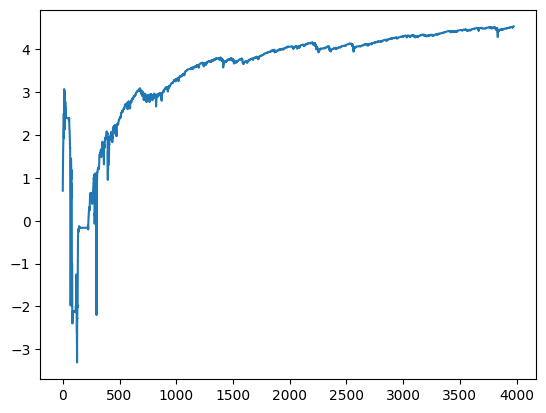

In [7]:
import matplotlib.pyplot as plt
plt.plot(clean.cumsum())
